In [ ]:
!pip install transformers

In [ ]:
!pip install pymorphy2

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from spacy.lang.ru import Russian
import nltk
from nltk.corpus import stopwords
from string import punctuation
nltk.download('stopwords')

russian_stopwords = stopwords.words("russian")
nlp = Russian()

def preprocess_text(text):
  sentence = nlp(text)
  tokens = [token.text for token in sentence]
  tokens = [token for token in tokens if token not in russian_stopwords\
            and token != " " \
            and token.strip() not in punctuation]
  
  text = " ".join(tokens)
  
  return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train = pd.read_csv('trainSet.csv')
test = pd.read_csv('testSet.csv')

In [ ]:
y_train = np.array(train['Class'])
y_test = np.array(test['Class'])

print(np.unique(y_train))
print(np.unique(y_test))

[ 1  3  8 21 22 23 31 32 41 42 43 44]
[ 1  3  8 21 22 23 31 32 41 42 43 44 51 52 53 54 55 56 57 58 59 60 61]


In [ ]:
test = test[test['Class'] <=44]

y_test = np.array(test['Class'])

print(np.unique(y_train))
print(np.unique(y_test))

[ 1  3  8 21 22 23 31 32 41 42 43 44]
[ 1  3  8 21 22 23 31 32 41 42 43 44]


In [ ]:
d = {}
inv_d = {}
l = np.unique(y_train)
for i in range(len(l)):
  d[i] = l[i]
  inv_d[l[i]] = i

print(d)
print(inv_d)

train_labels = np.array([inv_d[i] for i in y_train])
test_labels = np.array([inv_d[i] for i in y_test])
print(np.unique(train_labels))
print(np.unique(test_labels))
print(len(train_labels))
print(len(test_labels))

{0: 1, 1: 3, 2: 8, 3: 21, 4: 22, 5: 23, 6: 31, 7: 32, 8: 41, 9: 42, 10: 43, 11: 44}
{1: 0, 3: 1, 8: 2, 21: 3, 22: 4, 23: 5, 31: 6, 32: 7, 41: 8, 42: 9, 43: 10, 44: 11}
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 0  1  2  3  4  5  6  7  8  9 10 11]
2244
963


In [ ]:
t_train = train['Text'].apply(preprocess_text)
test_text = test['Text'].apply(preprocess_text)

print(len(t_train))
print(len(test_text))

2244
963


In [ ]:
train_text, val_text, train_labels, val_labels = train_test_split(t_train, train_labels, 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=train_labels)

In [ ]:
bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
tokenizer.get_vocab()

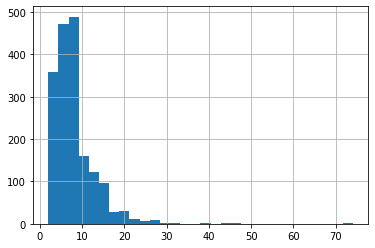

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

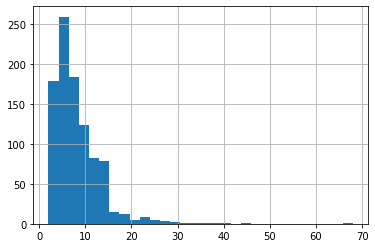

In [ ]:
seq_len = [len(i.split()) for i in test_text]

pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 30

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):

  def __init__(self, bert):
    
    super(BERT_Arch, self).__init__()

    self.bert = bert 
    
    # dropout layer
    self.dropout = nn.Dropout(0.1)
    
    # relu activation function
    self.relu =  nn.ReLU()

    # dense layer 1
    self.fc1 = nn.Linear(768,512)
    
    # dense layer 2 (Output layer)
    self.fc2 = nn.Linear(512,12)

    #softmax activation function
    self.softmax = nn.Softmax(dim=1)

  #define the forward pass
  def forward(self, sent_id, mask):

    #pass the inputs to the model  
    cls_hs = self.bert(sent_id, attention_mask=mask)[1]

    x = self.fc1(cls_hs)

    x = self.relu(x)

    x = self.dropout(x)

    # output layer
    x = self.fc2(x)
    
    # apply softmax activation
    #x = self.softmax(x)

    return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print(class_wts)

[0.69573643 0.92335391 0.7872807  0.7872807  1.03877315 1.2570028
 1.02454338 1.0608747  0.63652482 1.6259058  1.35984848 2.93300654]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
#cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy = nn.CrossEntropyLoss(weight=weights)
# number of training epochs
epochs = 150

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds


In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
  
  #train model
  train_loss, _ = train()
  
  #evaluate model
  valid_loss, _ = evaluate()
  
  #save the best model
  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      torch.save(model.state_dict(), 'saved_weights.pt')
  
  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  
  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 2.393
Validation Loss: 2.240

 Epoch 2 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 2.167
Validation Loss: 2.014

 Epoch 3 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.925
Validation Loss: 1.738

 Epoch 4 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.704
Validation Loss: 1.530

 Epoch 5 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.557
Validation Loss: 1.415

 Epoch 6 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.442
Validation Loss: 1.371

 Epoch 7 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.393
Validation Loss: 1.259

 Epoch 8 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.348
Validation Loss: 1.112

 Epoch 9 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.258
Validation Loss: 1.041

 Epoch 10 / 150
  Batch    50  of     57.

Evaluating...

Training Loss: 1.186
Va

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.96      0.93       122
           1       0.84      0.90      0.87        90
           2       0.92      0.67      0.77        81
           3       0.86      0.76      0.81       116
           4       0.76      0.90      0.83        93
           5       0.73      0.83      0.78        59
           6       0.75      0.86      0.80        76
           7       0.88      0.77      0.82        83
           8       0.77      0.84      0.81       109
           9       0.83      0.67      0.74        45
          10       0.87      0.69      0.77        58
          11       0.56      0.71      0.63        31

    accuracy                           0.82       963
   macro avg       0.81      0.80      0.80       963
weighted avg       0.82      0.82      0.82       963



In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(test_y, preds, average = 'macro')

0.7959158315916398